In [30]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [31]:
path = '../../HITS/test_9/2,5tempExp/new_header/' # found
#'../../HITS/test_29/4,2tempExp/new_header/' # masking issue
#'../../HITS/tract_5_5,3/' # no header
#'../../HITS/test_35/4,6tempExp/new_header/' # found (only 4 images)
#'../../HITS/test_27/3,5tempExp/new_header/' #found

In [32]:
files = os.listdir(path)

In [33]:
files.sort()
files = [path+f for f in files]
files = files[:10]
files

['../../HITS/test_9/2,5tempExp/new_header/v410903-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v410959-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411009-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411243-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411293-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411343-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411393-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411444-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411645-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411746-fg.fits']

In [34]:
images = [kb.layered_image(f) for f in files]

Object Generation Parameters

In [35]:
p = kb.psf(1.5)
object_count = 200
x_range = (5,3650)
y_range = (5, 3650)
angle_range = (0.1, 0.5)
velocity_range = (1900, 2900)
flux_range = (800, 4000)

Search Parameters

In [36]:
min_observations = 3
angle_steps = 120
velocity_steps = 100
search_margin = 1.2

In [37]:
print(angle_range[1]-angle_range[0])
print(velocity_range[1]-velocity_range[0])

0.4
1000


Generate Random trajectories within bounds

In [12]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    ang = rd.uniform(*angle_range)
    vel = rd.uniform(*velocity_range)
    traj.x_v = vel*math.cos(ang)
    traj.y_v = vel*math.sin(ang)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

Add a real object to the list of trajectories

In [10]:
if path == '../../HITS/test_35/4,6tempExp/new_header/':
    real_result = kb.trajectory()
    real_result.flux = 5300
    real_result.x = 3123
    real_result.y = 3043
    real_result.x_v = 2425
    real_result.y_v = 1050
    results_key.append(real_result)
results_key

[lh: 0.000000 flux: 2888.725830 x: 546 y: 3647 x_v: 1893.110840 y_v: 1026.875854 obs_count: 0,
 lh: 0.000000 flux: 2090.797119 x: 315 y: 2874 x_v: 2158.721924 y_v: 313.628326 obs_count: 0,
 lh: 0.000000 flux: 3681.117432 x: 634 y: 56 x_v: 2704.042236 y_v: 792.990295 obs_count: 0,
 lh: 0.000000 flux: 2557.867676 x: 2498 y: 333 x_v: 2047.552979 y_v: 823.647583 obs_count: 0,
 lh: 0.000000 flux: 2624.145508 x: 1219 y: 2560 x_v: 2254.996338 y_v: 631.401917 obs_count: 0,
 lh: 0.000000 flux: 3014.995605 x: 2374 y: 2819 x_v: 1910.045898 y_v: 470.608337 obs_count: 0,
 lh: 0.000000 flux: 3183.142090 x: 838 y: 2041 x_v: 2598.840088 y_v: 271.549377 obs_count: 0,
 lh: 0.000000 flux: 2041.275391 x: 3564 y: 3528 x_v: 1981.537598 y_v: 421.404510 obs_count: 0,
 lh: 0.000000 flux: 3279.229736 x: 3444 y: 2318 x_v: 2007.398193 y_v: 384.152863 obs_count: 0,
 lh: 0.000000 flux: 1669.270264 x: 602 y: 1748 x_v: 2231.090576 y_v: 1117.967896 obs_count: 0,
 lh: 0.000000 flux: 2203.696045 x: 599 y: 1798 x_v: 2032

Test that clustering is not able to collapse together too many unique trajectories

In [11]:
len(cluster_trajectories(results_key, dbscan_args=dict(eps=0.007, min_samples=1))[1])

201

Use the generated trajectories to add objects into the images

In [12]:
for t in results_key:
    add_trajectory(images, t, p)

Sanity check

In [13]:
len(match_trajectories(results_key, results_key, 0.01, 1)[0])

201

In [38]:
stack = kb.image_stack(images)

Mask out stars and bad pixels

In [39]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [40]:
stack.apply_mask_flags(flags, flag_exceptions)

In [41]:
stack.apply_master_mask(master_flags, 2)

In [42]:
images = [i.science() for i in stack.get_images()]

Calculate masked percentage of an image to estimate probablilty of placing an object under a mask

In [43]:
img = images[1]
percent_masked = img[np.where(img==kb.no_data)].size/img.size
percent_masked

0.32202664399092973

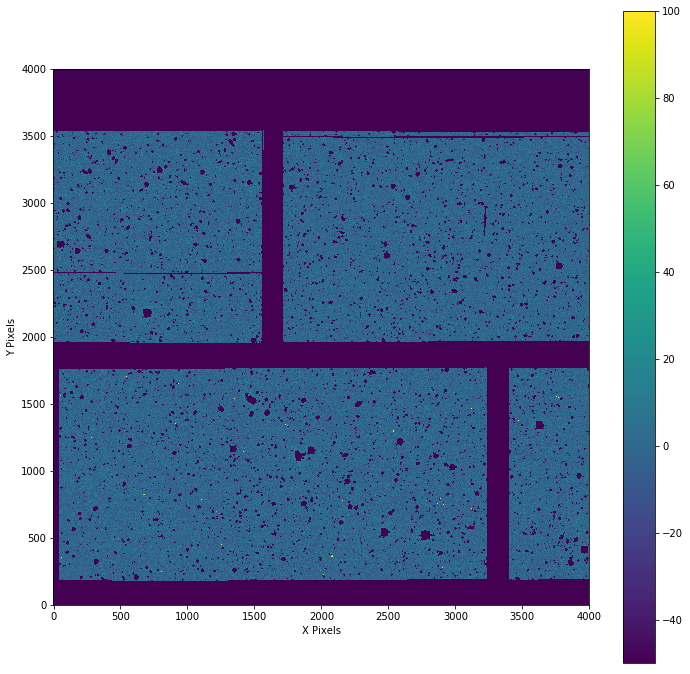

In [44]:
fig = plt.figure(figsize=(12,12))
plt.imshow(images[4] [0:4000,0:4000], origin='lower',  vmin=-50, vmax=100)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [47]:
search = kb.stack_search(stack, p)
search.set_debug(True)

In [ ]:
search_ang_r = (angle_range[0]/search_margin,
                angle_range[1]*search_margin)
search_vel_r = (velocity_range[0]/search_margin,
                velocity_range[1]*search_margin)
#search.gpu(angle_steps,velocity_steps, *angle_range, *velocity_range, min_observations)

In [ ]:
#search.get_results(0,20)

In [48]:
#search.region_search(2400, 1040, 50, 255, 3)
#  xvel, yvel, radius, minLH, minimum observations
res = search.region_search(200, 80, 180, 15, 6)

In [49]:
print(len(res))
res

267


[ix: 1460.000000 iy: 3275.000000 fx: 1821.000000 fy: 3449.000000 depth: 0 obs_count: 6 lh: 58.824558 flux 1286.998657,
 ix: 4042.000000 iy: 423.000000 fx: 4332.000000 fy: 629.000000 depth: 0 obs_count: 6 lh: 46.424747 flux 897.581177,
 ix: 2684.000000 iy: 722.000000 fx: 3263.000000 fy: 925.000000 depth: 0 obs_count: 7 lh: 36.674046 flux 633.647583,
 ix: 1366.000000 iy: 121.000000 fx: 1658.000000 fy: 277.000000 depth: 0 obs_count: 6 lh: 34.243526 flux 655.250854,
 ix: 801.000000 iy: 1254.000000 fx: 1037.000000 fy: 1452.000000 depth: 0 obs_count: 8 lh: 33.720188 flux 557.896179,
 ix: 3689.000000 iy: 316.000000 fx: 4237.000000 fy: 416.000000 depth: 0 obs_count: 6 lh: 32.898201 flux 634.101379,
 ix: 3868.000000 iy: 1407.000000 fx: 4334.000000 fy: 1588.000000 depth: 0 obs_count: 6 lh: 31.666164 flux 595.203552,
 ix: 1507.000000 iy: 1502.000000 fx: 2066.000000 fy: 1629.000000 depth: 0 obs_count: 9 lh: 30.148987 flux 466.739777,
 ix: 2877.000000 iy: 371.000000 fx: 3393.000000 fy: 676.000000 d

In [26]:
matched = []
for r in res:
    if any(abs(r.ix-t.x)<=1 and abs(r.iy-t.y)<=1 for t in results_key ):
        matched.append(r)
len(matched)

178

In [27]:
matched

[ix: 3124.000000 iy: 3043.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 262.363678 flux 9595.437500,
 ix: 1348.000000 iy: 1811.000000 fx: 1782.000000 fy: 1882.000000 depth: 0 obs_count: 4 lh: 174.175888 flux 3656.506348,
 ix: 769.000000 iy: 2214.000000 fx: 1206.000000 fy: 2413.000000 depth: 0 obs_count: 4 lh: 170.280563 flux 3577.969482,
 ix: 1135.000000 iy: 2385.000000 fx: 1707.000000 fy: 2487.000000 depth: 0 obs_count: 4 lh: 169.889465 flux 3545.012939,
 ix: 2123.000000 iy: 294.000000 fx: 2485.000000 fy: 471.000000 depth: 0 obs_count: 4 lh: 167.810989 flux 3555.443359,
 ix: 3174.000000 iy: 725.000000 fx: 3655.000000 fy: 954.000000 depth: 0 obs_count: 4 lh: 163.885025 flux 3517.426025,
 ix: 1419.000000 iy: 1609.000000 fx: 1969.000000 fy: 1754.000000 depth: 0 obs_count: 4 lh: 161.952271 flux 3403.200195,
 ix: 1369.000000 iy: 237.000000 fx: 1933.000000 fy: 324.000000 depth: 0 obs_count: 4 lh: 160.828766 flux 3419.048096,
 ix: 2840.000000 iy: 572.000000 fx: 3313.000000

# Examining Pooling

In [28]:
pooled = search.get_psi_pooled()

In [52]:
pooled_imgs = [np.array(im, copy=False) for im in pooled[1]]

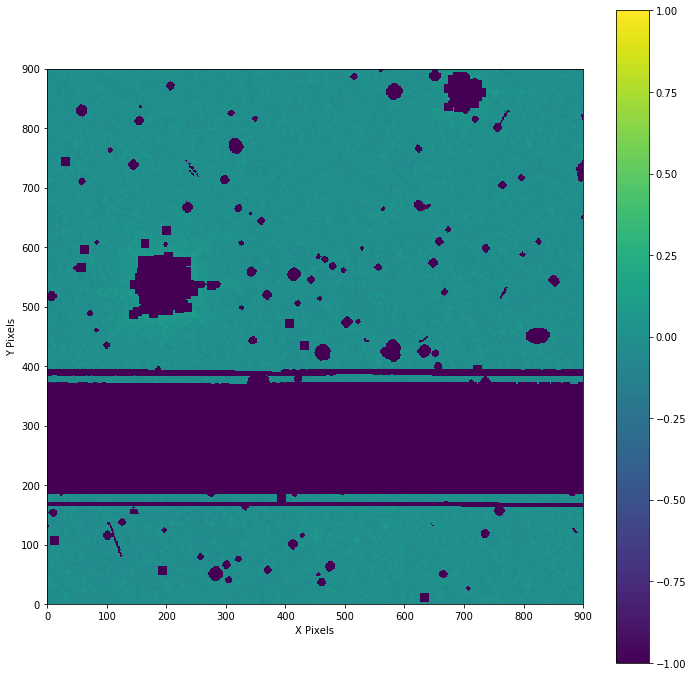

In [53]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[0] [2700:3600,2900:3800], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

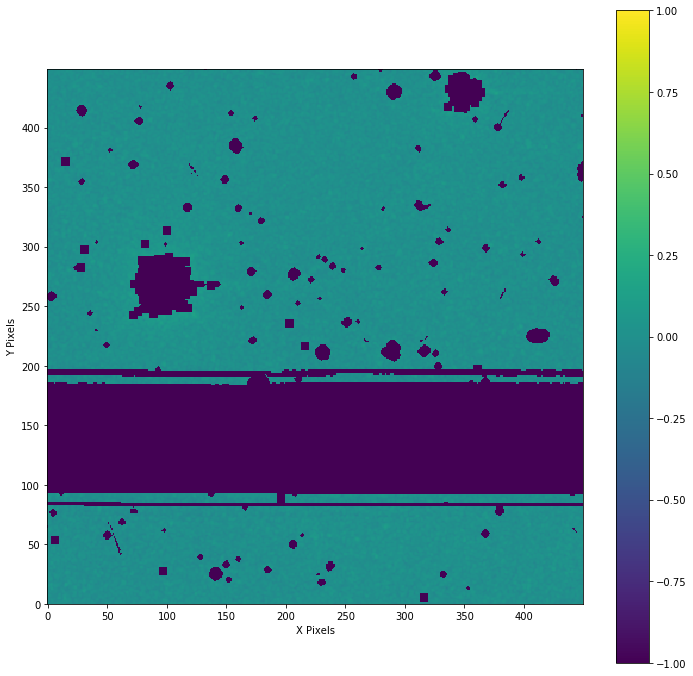

In [54]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[1] [1350:1800,1450:1900], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

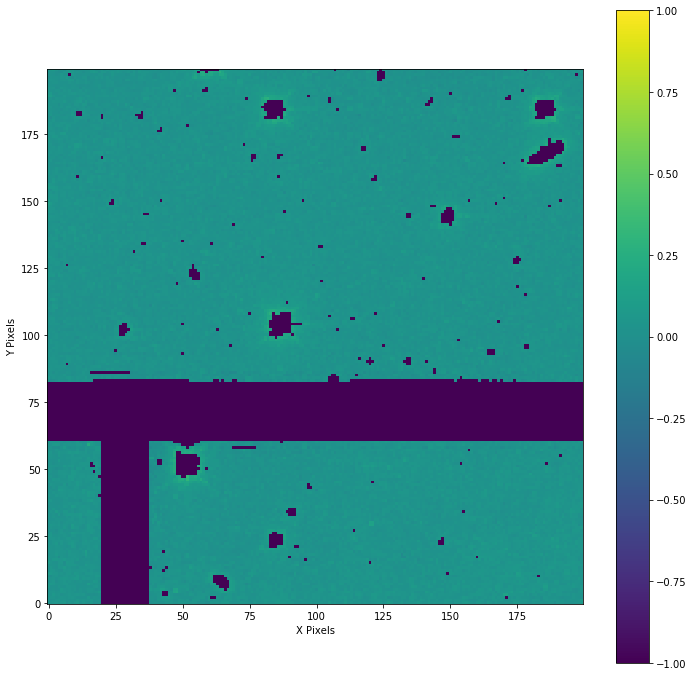

In [75]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[3] [300:500,300:500], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()